In [26]:
import torch
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
import pandas as pd
from torch.distributions import constraints
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from preprocessor import YelpData
from pyro.infer.autoguide import init_to_feasible

In [3]:
data_class = YelpData()

In [4]:
# only for first time 
# data_class.process()
# data = torch.from_numpy(data_class.add_bias().astype(np.float32))
# ratings = torch.from_numpy(data_class.ratings.to_numpy().astype(np.float32))
# data_class.to_pickle(data, 'data')
# data_class.to_pickle(ratings, 'ratings')

In [130]:
data = data_class.load('data')
ratings = data_class.load('ratings')
num_features = data.shape[1] - 1

In [111]:
def model(data, ratings):
#     betas = []

    #bias
#     betas.append(pyro.sample("beta_0", dist.Normal(0, 1)))
    #make one-hot vector length betas
    with pyro.plate("betas", num_features + 1):
        betas = pyro.sample("beta", dist.Gamma(1,1))
#     for i in range(num_feature):
#         betas.append(pyro.sample("beta_{}".format(i + 1), dist.Normal(0, 1)))

#     betas = torch.from_numpy(np.array(betas))
#     print(betas.dtype)
    lambda_ = torch.exp(torch.sum(betas * data,axis=1))
#     import pdb
#     pdb.set_trace()
    with pyro.plate("ratings", data.shape[0]):
        y = pyro.sample("obs", dist.Poisson(lambda_), obs = ratings)
#     import pdb
#     pdb.set_trace()
    return y
# model(data, ratings)

In [112]:
def guide(data, ratings):
    alphas_0 = pyro.param('weights_loc', torch.ones(546),  constraint=constraints.positive)
    alphas_1 = pyro.param('weights_scale', torch.ones(546), constraint=constraints.positive)        
#     weights_loc = pyro.param('weights_loc', torch.randn(2))
#     weights_scale = pyro.param('weights_scale', torch.ones(2), constraint=constraints.positive)        

    with pyro.plate("betas", num_features + 1):
        betas = pyro.sample("beta", dist.Gamma(alphas_0, alphas_1))
  


In [11]:
# def guide(rating, rating_ns, popularity):
#     weights_loc = pyro.param('weights_loc', torch.randn(3))
#     weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)        
# #     weights_loc = pyro.param('weights_loc', torch.randn(2))
# #     weights_scale = pyro.param('weights_scale', torch.ones(2), constraint=constraints.positive)        

    
#     beta_0 = pyro.sample("beta_0", dist.Normal(weights_loc[0], weights_scale[0]))
#     beta_1 = pyro.sample("beta_1", dist.Normal(weights_loc[1], weights_scale[1]))
#     beta_2 = pyro.sample("beta_2", dist.Normal(weights_loc[2], weights_scale[2]))
#     labmda_ = torch.exp(beta_0 + beta_1 * rating + beta_2 * rating_ns)
# #     labmda_ = torch.exp(beta_0 + beta_1 * rating)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)
# guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

In [113]:
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

# pyro.clear_param_store()
epoch = 10000
for i in range(epoch):
    ELBO = svi.step(data, ratings)
    if i % 500 == 0:
        print(ELBO)


116965297356800.0
430339620864.0
5821478993920.0


KeyboardInterrupt: 

In [13]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(data, ratings)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 1200/1200 [3:03:59<00:00,  9.75s/it, step size=2.34e-02, acc. prob=0.922] 


In [15]:
#data_class.to_pickle(hmc_samples, 'hmc_samples')

In [16]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [21]:
svi_diagnorm_posterior = svi.run(data,ratings)
sites = ["betas"]

svi_samples = {site: EmpiricalMarginal(svi_diagnorm_posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: betas
      mean  std     5%    25%    50%    75%    95%
0      0.0  0.0    0.0    0.0    0.0    0.0    0.0
1      1.0  0.0    1.0    1.0    1.0    1.0    1.0
2      2.0  0.0    2.0    2.0    2.0    2.0    2.0
3      3.0  0.0    3.0    3.0    3.0    3.0    3.0
4      4.0  0.0    4.0    4.0    4.0    4.0    4.0
..     ...  ...    ...    ...    ...    ...    ...
541  541.0  0.0  541.0  541.0  541.0  541.0  541.0
542  542.0  0.0  542.0  542.0  542.0  542.0  542.0
543  543.0  0.0  543.0  543.0  543.0  543.0  543.0
544  544.0  0.0  544.0  544.0  544.0  544.0  544.0
545  545.0  0.0  545.0  545.0  545.0  545.0  545.0

[546 rows x 7 columns] 



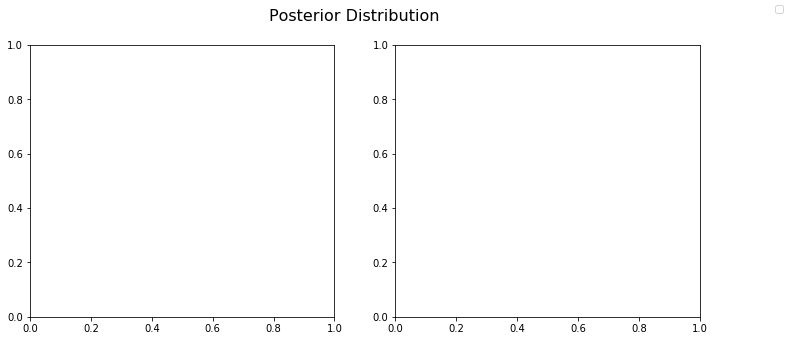

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle("Posterior Distribution", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    try:
        site = sites[i]
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
        sns.distplot(svi_samples[site], ax=ax, label="SVI")
        ax.set_title(site)
    except:
        pass
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [ ]:
# #MLE

# #variables
# MLE_thetas = torch.ones(train_data.shape[1] - 1, requires_grad = True)
# def neg_log_likelihood(x,y):
#     theta_times_x = MLE_thetas * x
#     log_likelihood = torch.sum(y * theta_times_x - torch.exp(theta_times_x))
#     return -log_likelihood

# def get_MLE(x, y):
#     epoch = 10000
#     optimizer = torch.optim.Adam([MLE_thetas])
#     for i in range(epoch):

#         optimizer.zero_grad()
#         target = neg_log_likelihood(x,y)
#         target.backward()
#         optimizer.step()

# get_MLE(train_data[:,:2],train_data[:,2:])

In [ ]:
MLE_thetas

In [9]:
#MLE

#variables
MLE_thetas = torch.ones([548,1], requires_grad = True, dtype = torch.float32)
def neg_log_likelihood(x,y):
#     import pdb
#     pdb.set_trace()
    theta_times_x = torch.matmul(x, MLE_thetas)


    log_likelihood = torch.matmul(y, theta_times_x) + torch.sum(torch.exp(theta_times_x))
#     torch.sum(y * theta_times_x - torch.exp(theta_times_x))
    return -log_likelihood

def get_MLE(x, y):
    epoch = 1000
    optimizer = torch.optim.Adam([MLE_thetas])
    for i in range(epoch):

        optimizer.zero_grad()
        target = neg_log_likelihood(x,y)
#         print(target)
        target.backward()
        optimizer.step()

get_MLE(data, ratings)

In [10]:
MLE_thetas

tensor([[3.5136],
        [4.2317],
        [3.7128],
        [2.7420],
        [1.2363],
        [4.0657],
        [4.3124],
        [3.5248],
        [4.0266],
        [1.2363],
        [3.0732],
        [3.2069],
        [3.5548],
        [1.2363],
        [3.9610],
        [4.2634],
        [4.3900],
        [3.5367],
        [4.2208],
        [4.1062],
        [4.2268],
        [2.2122],
        [4.3321],
        [3.9244],
        [3.9843],
        [4.3715],
        [3.9043],
        [4.1201],
        [2.2122],
        [3.2042],
        [3.0741],
        [4.5127],
        [3.0742],
        [4.0018],
        [3.3578],
        [4.1247],
        [3.5959],
        [4.2773],
        [4.3532],
        [4.1354],
        [1.2363],
        [2.3087],
        [2.3087],
        [4.1038],
        [4.0225],
        [3.9273],
        [4.3853],
        [3.9795],
        [3.9377],
        [3.3540],
        [3.1862],
        [3.8257],
        [2.7416],
        [4.2225],
        [2.7477],
        [3

In [107]:
data = data[0:1000]
ratings = ratings[0:1000]
svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

# pyro.clear_param_store()
epoch = 10000
for i in range(epoch):
    ELBO = svi.step(data, ratings)
    if i % 500 == 0:
        print(ELBO)

3509.788818359375
3497.69677734375
3503.044921875
3499.607421875
3498.625
3500.585205078125
3497.366455078125
3495.91162109375
3500.0478515625
3500.71533203125
3503.013671875
3497.597900390625
3497.198486328125
3499.1767578125
3500.389404296875
3499.22314453125
3502.1953125
3497.076171875
3499.54150390625
3497.49755859375


In [108]:

posterior = svi.run(data, ratings)
sites = ["betas"]

svi_samples = {site: EmpiricalMarginal(posterior, sites=site)
                     .enumerate_support().detach().cpu().numpy()
               for site in sites}
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")
    
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
def wrapped_model(data, ratings):
    pyro.sample("prediction", dist.Delta(model(data, ratings)))
trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=500)
post_pred = trace_pred.run(data, None)
marginal = get_marginal(post_pred, ["prediction"])
    

Site: betas
      mean  std     5%    25%    50%    75%    95%
0      0.0  0.0    0.0    0.0    0.0    0.0    0.0
1      1.0  0.0    1.0    1.0    1.0    1.0    1.0
2      2.0  0.0    2.0    2.0    2.0    2.0    2.0
3      3.0  0.0    3.0    3.0    3.0    3.0    3.0
4      4.0  0.0    4.0    4.0    4.0    4.0    4.0
..     ...  ...    ...    ...    ...    ...    ...
541  541.0  0.0  541.0  541.0  541.0  541.0  541.0
542  542.0  0.0  542.0  542.0  542.0  542.0  542.0
543  543.0  0.0  543.0  543.0  543.0  543.0  543.0
544  544.0  0.0  544.0  544.0  544.0  544.0  544.0
545  545.0  0.0  545.0  545.0  545.0  545.0  545.0

[546 rows x 7 columns] 



In [109]:
marginal.max()

9.0

In [118]:
sample_median = np.mean(marginal,axis=2)
sample_median = sample_median.flatten()
dist_ratings = ratings.detach().numpy()
sns.set()

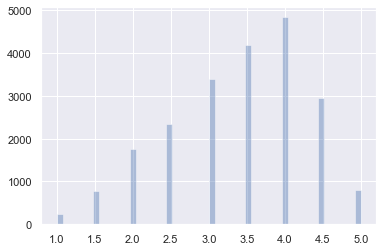

In [115]:
ax = sns.distplot(dist_ratings,kde=False)

In [128]:
0.5 in dist_ratings

False

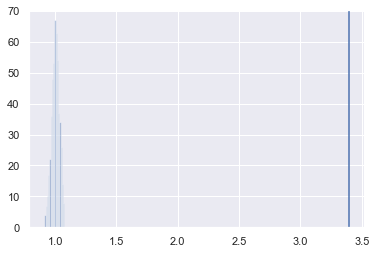

In [122]:
ax = sns.distplot(sample_median,kde=False)
plt.axvline(np.mean(dist_ratings), 0,1)

In [117]:
np.median(dist_ratings)

3.5

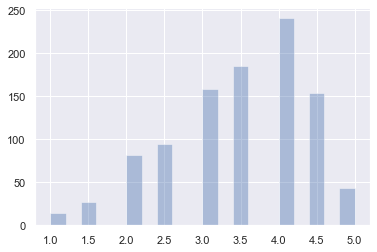

In [96]:
sns.set()


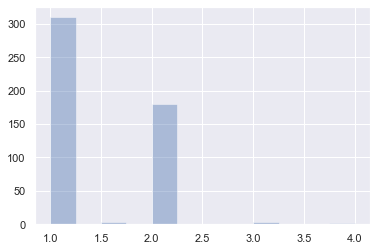

In [255]:
def multinomial_model(data, ratings):
    #make one-hot vector length betas
    mu = 0
    sigma = 1
    with pyro.plate("betas", num_features+1):
        
        beta_1 = pyro.sample("beta_1", dist.Normal(mu, sigma))
        beta_1h = pyro.sample("beta_1h", dist.Normal(mu, sigma))
        beta_2 = pyro.sample("beta_2", dist.Normal(mu, sigma))
        beta_2h = pyro.sample("beta_2h", dist.Normal(mu, sigma))
        beta_3 = pyro.sample("beta_3", dist.Normal(mu, sigma))
        beta_3h = pyro.sample("beta_3h", dist.Normal(mu, sigma))
        beta_4 = pyro.sample("beta_4", dist.Normal(mu, sigma))
        beta_4h = pyro.sample("beta_4h", dist.Normal(mu, sigma))
        #beta_5 = pyro.sample("beta_5", dist.Normal(mu, sigma))
    p_1 = torch.sum(beta_1 * data,axis=1)
    p_1h = torch.sum(beta_1h * data,axis=1)
    p_2 = torch.sum(beta_2 * data,axis=1)
    p_2h = torch.sum(beta_2h * data,axis=1)
    p_3 = torch.sum(beta_3 * data,axis=1)
    p_3h = torch.sum(beta_3h * data,axis=1)
    p_4 = torch.sum(beta_4 * data,axis=1)
    p_4h = torch.sum(beta_4h * data,axis=1)
    #p_5 = torch.sum(beta_5 * data,axis=1)

    p_array = torch.stack([p_1,p_1h,p_2,p_2h,p_3,p_3h,p_4,p_4h])
    exp_sum = torch.sum(torch.exp(p_array),axis=0)

    softmax_array=(torch.exp(p_array) / (1+exp_sum))
    temp_total = torch.sum(softmax_array, axis = 0)
    last_par = torch.unsqueeze(1 - temp_total, dim = 0)

    softmax_array = torch.cat([softmax_array, last_par], axis = 0).T

    with pyro.plate("ratings", data.shape[0]):
        y = pyro.sample("obs", dist.Categorical(probs=softmax_array), obs = ratings)

    return y


In [256]:
data = data_class.load('data')
ratings = data_class.load('ratings')
num_features = data.shape[1] - 1

In [288]:
nuts_kernel = NUTS(multinomial_model)

mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100)
mcmc.run(data[:10000], ratings[:10000])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 200/200 [1:10:40<00:00,  8.28s/it, step size=6.11e-02, acc. prob=0.801]


In [ ]:
#luann
# def test(betas, data):
  
#     p_1 = torch.matmul(torch.from_numpy(betas['beta_1']),data.T)
#     p_1h = torch.matmul(torch.from_numpy(betas['beta_1h']),data.T)
#     p_2 = torch.matmul(torch.from_numpy(betas['beta_2']), data.T)
#     p_2h = torch.matmul(torch.from_numpy(betas['beta_2h']), data.T)
#     p_3 = torch.matmul(torch.from_numpy(betas['beta_3']), data.T)
#     p_3h = torch.matmul(torch.from_numpy(betas['beta_3h']), data.T)
#     p_4 = torch.matmul(torch.from_numpy(betas['beta_4']), data.T)
#     p_4h = torch.matmul(torch.from_numpy(betas['beta_4h']), data.T)
#     #p_5 = torch.sum(beta_5 * data,axis=1)
# #     import pdb
# #     pdb.set_trace()
#     p_array = torch.exp(torch.stack([p_1,p_1h,p_2,p_2h,p_3,p_3h,p_4,p_4h]))
#     exp_sum = torch.sum(p_array,axis=0)

#     softmax_array=np.divide(p_array,1+exp_sum)
#     temp_total = torch.sum(softmax_array, axis = 0)
#     last_par = torch.unsqueeze(1 - temp_total, dim = 0)

#     softmax_array = torch.cat([softmax_array, last_par], axis = 0).T

#     y = pyro.sample("obs", dist.Categorical(probs=softmax_array))
#     return y
# res = test(hmc_samples, data[:20])

In [298]:
def test(betas, data):
  
    p_1 = torch.matmul(torch.from_numpy(betas['beta_1']),data.T)
    p_1h = torch.matmul(torch.from_numpy(betas['beta_1h']),data.T)
    p_2 = torch.matmul(torch.from_numpy(betas['beta_2']), data.T)
    p_2h = torch.matmul(torch.from_numpy(betas['beta_2h']), data.T)
    p_3 = torch.matmul(torch.from_numpy(betas['beta_3']), data.T)
    p_3h = torch.matmul(torch.from_numpy(betas['beta_3h']), data.T)
    p_4 = torch.matmul(torch.from_numpy(betas['beta_4']), data.T)
    p_4h = torch.matmul(torch.from_numpy(betas['beta_4h']), data.T)

    p_array = torch.exp(torch.stack([p_1,p_1h,p_2,p_2h,p_3,p_3h,p_4,p_4h], axis=1))
    exp_sum = torch.sum(p_array,axis=1)
    exp_sum_inv = torch.unsqueeze(1/(exp_sum + 1), axis = 1)
    for i in range(3):
        exp_sum_inv = torch.cat([exp_sum_inv,exp_sum_inv], axis = 1)

    softmax_array=(p_array * exp_sum_inv)

    temp_total = torch.sum(softmax_array, axis = 1)
    last_par = torch.unsqueeze(1 - temp_total, dim = 1)
    last_par[last_par < 0] = 0
    softmax_array = torch.cat([softmax_array, last_par], axis = 1).transpose(1,2)

    y = pyro.sample("obs", dist.Categorical(probs=softmax_array))
    return y
res = test(hmc_samples, data[:10000])

In [318]:
ratings.shape

torch.Size([21311])

(array([ 115.,  370.,  801., 1058., 1611., 2009., 2247., 1403.,  386.]),
 array([0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]),
 <a list of 9 Patch objects>)

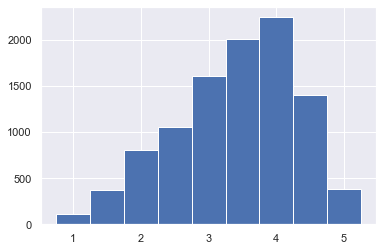

In [326]:
plt.hist(ratings[:10000],bins=np.array([1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])-0.25)

(array([0.000e+00, 0.000e+00, 4.940e+02, 1.917e+03, 2.474e+03, 3.978e+03,
        1.083e+03, 5.200e+01, 2.000e+00]),
 array([0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]),
 <a list of 9 Patch objects>)

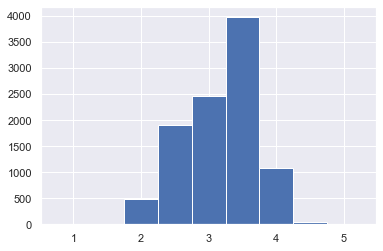

In [327]:
plt.hist(res_avg,bins=np.array([1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])-0.25)

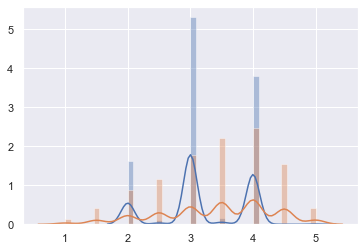

In [325]:
ax = sns.distplot(res_med)
ax = sns.distplot(ratings[:10000])

In [324]:
res_avg = np.average(res,axis=0)
res_med = np.median(res, axis = 0)

(array([   0.,   67., 1231., 2084., 3692., 2670.,  245.,   11.,    0.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 9 Patch objects>)

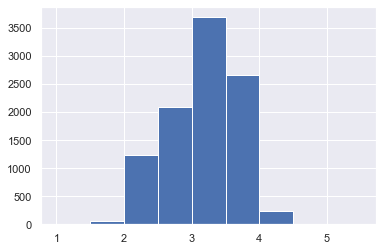

In [305]:
plt.hist(res_avg, bins=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])

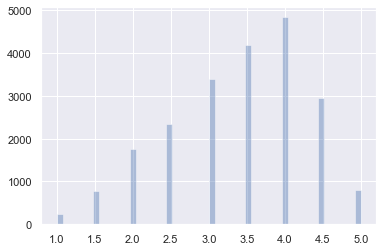

In [286]:
ax = sns.distplot(ratings,kde=False)

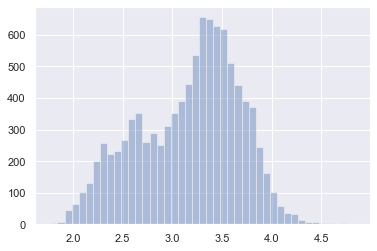

In [306]:
ax = sns.distplot(res_avg,kde=False)


In [342]:
"4" > "3" 

True

In [343]:
ret_str = "??:??"

In [344]:
for i in range(len(ret_str)):
    print(ret_str[i])

?
?
:
?
?


In [346]:
"1A" >"1B"

False